# Analisis Pola Konsumsi Energi Rumah Tangga

## 1. Import Library & Konfigurasi Awal
Tahap ini bertujuan untuk memuat pusataka (library) Python yang dibutuhkan untuk manipulasi data, visualisasi, dan pemodelan machine learning, serta mengatur konfigurasi tampilan plot.



In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

# Konfigurasi Visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12



## 2. Data Loading
Tahap ini bertujuan untuk membaca dataset dari file CSV lokal ke dalam struktur data DataFrame agar dapat diolah lebih lanjut.



In [69]:
# Load dataset
try:
    df = pd.read_csv('data/Smart Home Dataset.csv')
    print("Dataset berhasil diload.")
except FileNotFoundError:
    print("File dataset tidak ditemukan. Pastikan path 'data/Smart Home Dataset.csv' sudah benar.")

# Menampilkan informasi dasar dataset
print(f"Dimensi Dataset: {df.shape}")
display(df.head())
print("-" * 50)
df.info()



Dataset berhasil diload.
Dimensi Dataset: (503911, 32)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503911 entries, 0 to 503910
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   time                 503911 non-null  object 
 1   use [kW]             503910 non-null  float64
 2   gen [kW]             503910 non-null  float64
 3   House overall [kW]   503910 non-null  float64
 4   Dishwasher [kW]      503910 non-null  float64
 5   Furnace 1 [kW]       503910 non-null  float64
 6   Furnace 2 [kW]       503910 non-null  float64
 7   Home office [kW]     503910 non-null  float64
 8   Fridge [kW]          503910 non-null  float64
 9   Wine cellar [kW]     503910 non-null  float64
 10  Garage door [kW]     503910 non-null  float64
 11  Kitchen 12 [kW]      503910 non-null  float64
 12  Kitchen 14 [kW]      503910 non-null  float64
 13  Kitchen 38 [kW]      503910 non-null  float64
 14  Barn [kW]        

## 3. Data Preprocessing
Tahap ini bertujuan untuk membersihkan dan mempersiapkan data, meliputi:
1. Penanganan nilai yang hilang (missing values).
2. Penghapusan data duplikat.
3. Konversi format waktu.
4. Rekayasa fitur (Feature Engineering) untuk mendapatkan variabilitas waktu.
5. Normalisasi data numerik untuk menyamakan skala antar fitur.



In [70]:
# 3.1 Handling Missing Values
# Mengecek missing value
print("Missing values per kolom:")
print(df.isnull().sum())

# Pendekatan: Drop jika sedikit, atau Imputasi jika perlu.
df = df.dropna()

# 3.2 Handling Duplicates
df = df.drop_duplicates()
print(f"Dimensi setelah cleaning: {df.shape}")

# 3.3 Konversi Kolom Timestamp
time_col = None
for col in df.columns:
    if 'time' in col.lower() or 'date' in col.lower():
        time_col = col
        break

if time_col:
    # Standardisasi Konversi Waktu (Unix Timestamp -> Datetime)
    # 1. Pastikan kolom terbaca sebagai numerik (float/int)
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    
    # 2. Hapus baris dengan nilai waktu tidak valid (NaN)
    df = df.dropna(subset=[time_col])
    
    # 3. Konversi menjadi objek datetime (unit='s' untuk detik)
    df[time_col] = pd.to_datetime(df[time_col], unit='s')
    
    # 4. Urutkan data berdasarkan waktu
    df = df.sort_values(by=time_col)
    
    print("Konversi waktu selesai.")
else:
    print("Kolom waktu tidak ditemukan. Mohon cek nama kolom.")

# 3.4 Feature Engineering
if time_col:
    df['hour'] = df[time_col].dt.hour
    df['day'] = df[time_col].dt.day
    df['weekday'] = df[time_col].dt.weekday
    df['month'] = df[time_col].dt.month
    print("Feature Engineering selesai: hour, day, weekday, month ditambahkan.")

# Identifikasi Kolom Target dan Fitur
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'use [kW]' in df.columns:
    target_col = 'use [kW]'
elif 'Energy_Consumption' in df.columns:
    target_col = 'Energy_Consumption'
else:
    target_col = num_cols[0]

print(f"Target Column identified as: {target_col}")



Missing values per kolom:
time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64
Dimensi setelah cleaning: (503910, 32)
Konversi waktu selesai.
Feature Engineering selesai: hour, day, weekday, month ditambahkan.
Target Column identified as: u

In [71]:
# 3.5 Normalisasi Fitur Numerik
scaler = MinMaxScaler()
# Pilih fitur yang akan dinormalisasi (kecuali fitur waktu hasil engineering, opsional)
cols_to_scale = [c for c in num_cols if c not in ['hour', 'day', 'weekday', 'month']]
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

display(df_scaled.head())



,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,hour,day,weekday,month
0,2016-01-01 05:00:00,0.063395,0.005674,0.063395,0.000024,0.010694,0.077812,0.455455,0.145775,0.005469,...,0.400698,cloudCover,0.785515,0.0,0.502677,0.0,5,1,4,1
1,2016-01-01 05:00:01,0.063497,0.005647,0.063497,0.000000,0.010703,0.080202,0.456930,0.145598,0.005469,...,0.400698,cloudCover,0.785515,0.0,0.502677,0.0,5,1,4,1
2,2016-01-01 05:00:02,0.063326,0.005647,0.063326,0.000012,0.010694,0.078315,0.458988,0.145050,0.005469,...,0.400698,cloudCover,0.785515,0.0,0.502677,0.0,5,1,4,1
3,2016-01-01 05:00:03,0.069458,0.005674,0.069458,0.000012,0.055264,0.086115,0.459520,0.144580,0.005469,...,0.400698,cloudCover,0.785515,0.0,0.502677,0.0,5,1,4,1
4,2016-01-01 05:00:04,0.077433,0.005647,0.077433,0.000095,0.122497,0.080412,0.459468,0.144247,0.005364,...,0.400698,cloudCover,0.785515,0.0,0.502677,0.0,5,1,4,1


## 4. Exploratory Data Analysis (EDA)
Tahap ini bertujuan untuk menganalisis karakteristik data secara visual, termasuk melihat tren konsumsi energi, distribusi data, dan korelasi antar variabel.



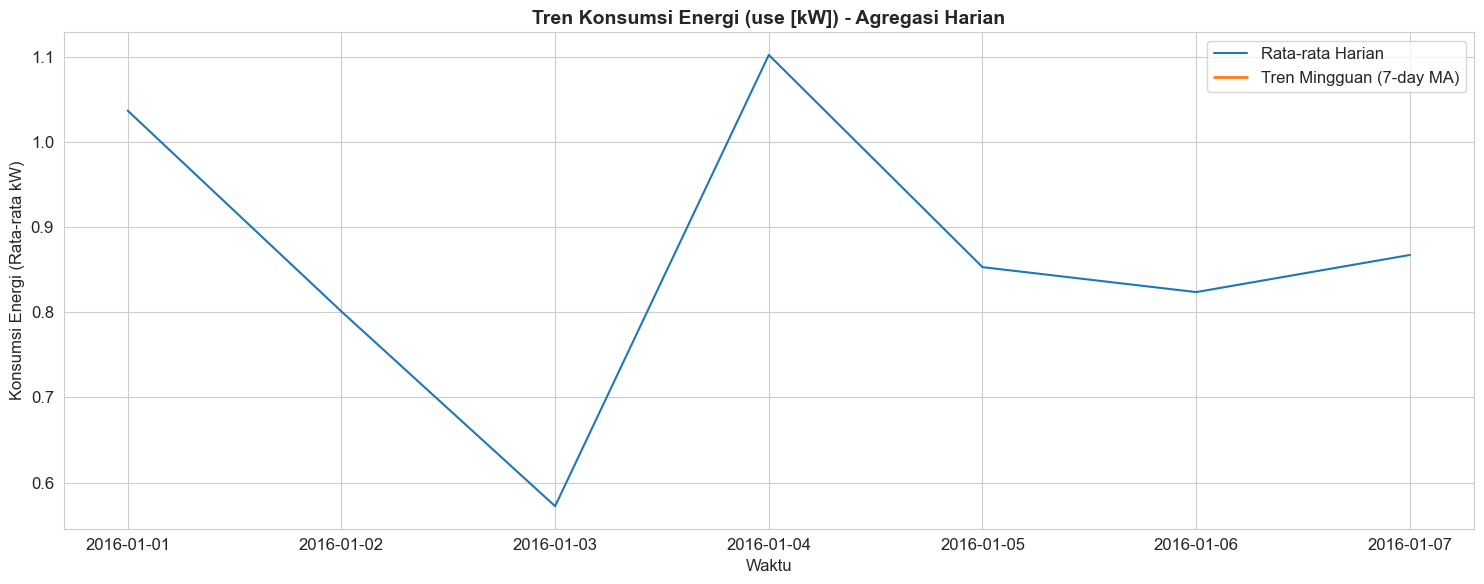

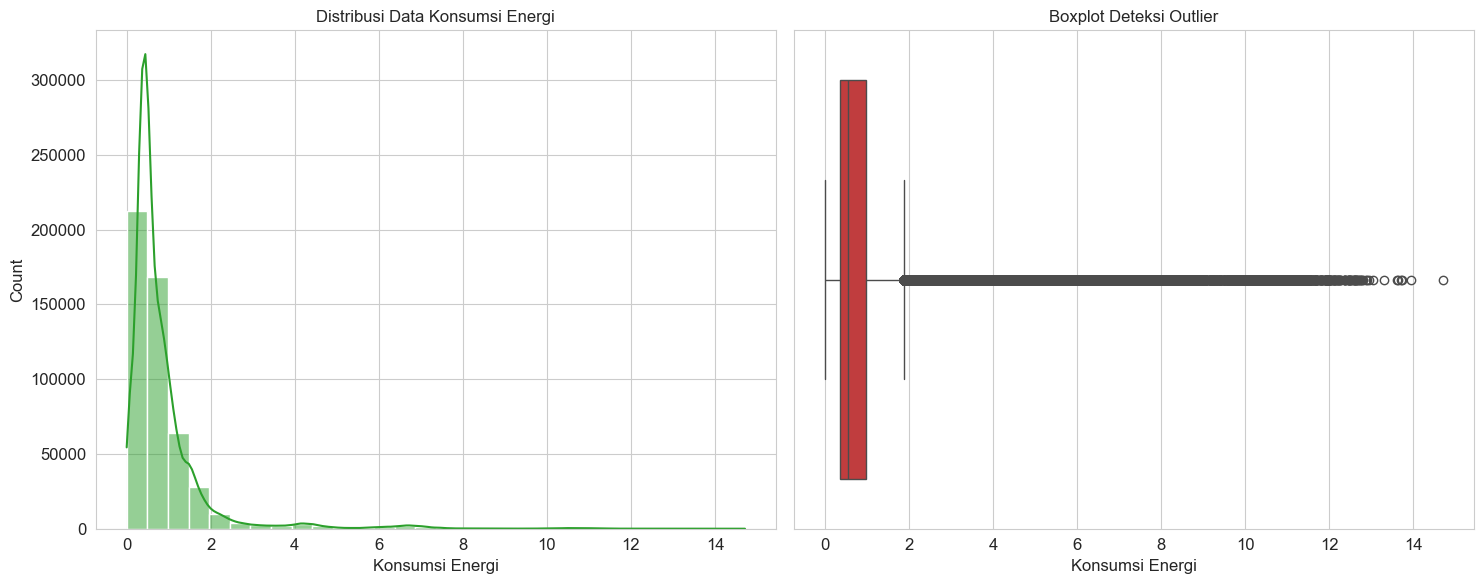

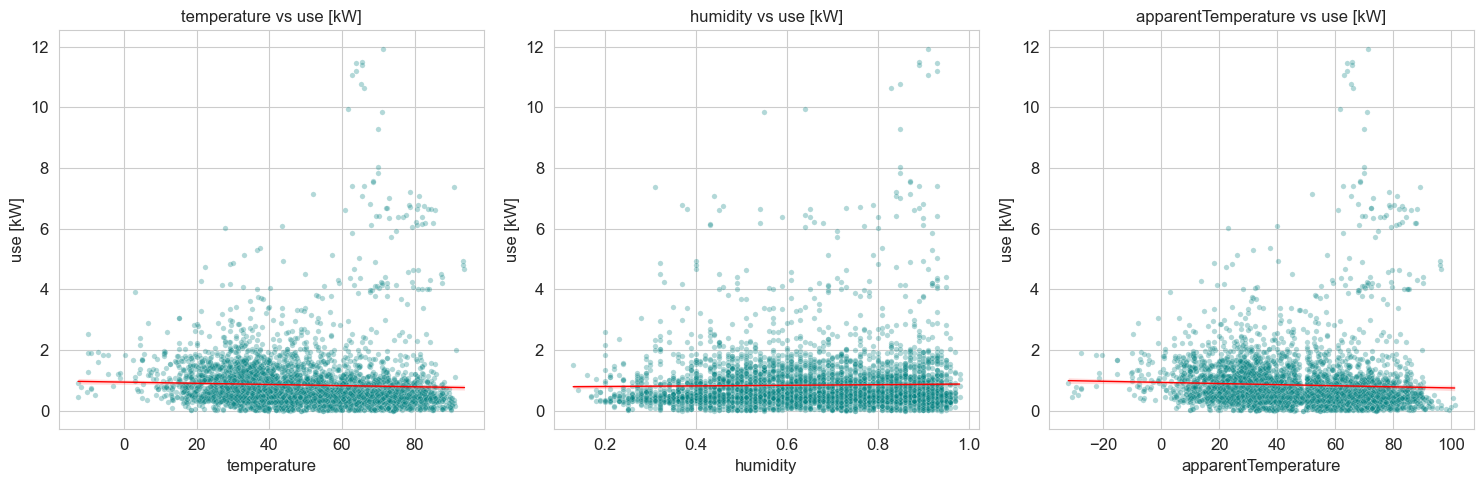

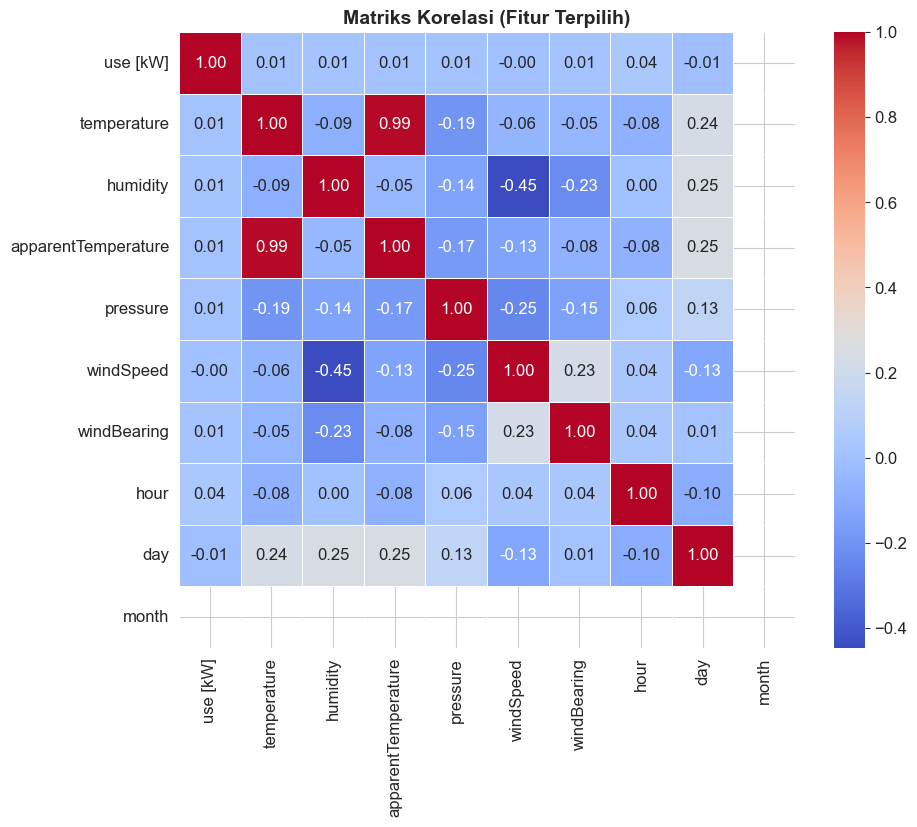

In [72]:
# 4.1 Line Chart Konsumsi Energi (Resampled)
# Plotting data mentah (misal per menit/jam) untuk setahun akan sangat padat.
# Kita lakukan Resampling menjadi rata-rata Harian (Daily) agar grafik lebih rapi dan terbaca trennya.
if time_col:
    # Use numeric_only=True to prevent errors with non-numeric columns during mean aggregation
    df_daily = df.resample('D', on=time_col).mean(numeric_only=True)
else:
    df_daily = df # Fallback

plt.figure(figsize=(15, 6))
# Plot Daily Average
plt.plot(df_daily.index, df_daily[target_col], linewidth=1.5, color='#1f77b4', label='Rata-rata Harian')
# Opsional: Rolling Average 7 hari (Weekly trend)
df_weekly_roll = df_daily[target_col].rolling(window=7).mean()
# Pastikan tidak ada NaN di rolling sebelum plotting (opsional, matplotlib handle NaN dengan break line)
plt.plot(df_daily.index, df_weekly_roll, linewidth=2, color='#ff7f0e', label='Tren Mingguan (7-day MA)')

plt.title(f'Tren Konsumsi Energi ({target_col}) - Agregasi Harian', fontsize=14, fontweight='bold')
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Konsumsi Energi (Rata-rata kW)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# 4.2 Distribusi Konsumsi Energi
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(df[target_col], kde=True, ax=axes[0], color='#2ca02c', bins=30)
axes[0].set_title('Distribusi Data Konsumsi Energi', fontsize=12)
axes[0].set_xlabel('Konsumsi Energi')

sns.boxplot(x=df[target_col], ax=axes[1], color='#d62728')
axes[1].set_title('Boxplot Deteksi Outlier', fontsize=12)
axes[1].set_xlabel('Konsumsi Energi')

plt.tight_layout()
plt.show()

# 4.3 Hubungan Cuaca vs Energi (Scatter plot rapi)
# Menggunakan filter sampel untuk mengurangi overplotting
weather_cols = [c for c in df.columns if any(x in c.lower() for x in ['temp', 'humid', 'pressure', 'wind'])]

if len(weather_cols) > 0:
    # Ambil max 3 variabel cuaca untuk ditampilkan
    cols_to_plot = weather_cols[:3]
    fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(5*len(cols_to_plot), 5))
    if len(cols_to_plot) == 1: axes = [axes] # Handle single plot case
    
    for i, w_col in enumerate(cols_to_plot):
        # Sample data jika terlalu besar (>5000) agar plot ringan & jelas
        plot_data = df.sample(5000, random_state=42) if len(df) > 5000 else df
        
        # Plot dengan alpha kecil dan size kecil
        sns.scatterplot(x=plot_data[w_col], y=plot_data[target_col], ax=axes[i], alpha=0.3, s=15, color='teal')
        
        # Tambahkan garis tren regresi sederhana untuk memperjelas hubungan
        sns.regplot(x=plot_data[w_col], y=plot_data[target_col], ax=axes[i], scatter=False, color='red', line_kws={'linewidth':1})

        axes[i].set_title(f'{w_col} vs {target_col}', fontsize=12)
        axes[i].set_xlabel(w_col)
        axes[i].set_ylabel(target_col)
        
    plt.tight_layout()
    plt.show()

# 4.4 Heatmap Korelasi
plt.figure(figsize=(10, 8))
# Kita hanya ambil kolom-kolom numeric utama agar tidak terlalu ramai
selected_cols = [target_col] + weather_cols + ['hour', 'day', 'month']
# Pastikan kolom ada
selected_cols = [c for c in selected_cols if c in df.columns]

corr_matrix = df[selected_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title('Matriks Korelasi (Fitur Terpilih)', fontsize=14, fontweight='bold')
plt.show()



## 5. Seleksi Fitur
Tahap ini bertujuan untuk memilih variabel-variabel yang paling berpengaruh terhadap konsumsi energi berdasarkan nilai korelasi, untuk meningkatkan efisiensi model.



In [73]:
# Ambil korelasi absolut terhadap target
correlation_target = abs(corr_matrix[target_col])
# Pilih fitur dengan korelasi > 0.05
relevant_features = correlation_target[correlation_target > 0.05].index.tolist()
relevant_features = [f for f in relevant_features if f != target_col] 

# Fallback: Jika tidak ada fitur yang memenuhi threshold, ambil semua fitur numerik (kecuali target)
if not relevant_features:
    print("Peringatan: Tidak ada fitur dengan korelasi > 0.05. Menggunakan semua fitur numerik.")
    relevant_features = [c for c in num_cols if c != target_col]

print(f"Fitur terpilih ({len(relevant_features)}):", relevant_features)



Peringatan: Tidak ada fitur dengan korelasi > 0.05. Menggunakan semua fitur numerik.
Fitur terpilih (31): ['gen [kW]', 'House overall [kW]', 'Dishwasher [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability', 'hour', 'day', 'weekday', 'month']


## 6. Clustering (Descriptive Analytics)
Tahap ini bertujuan untuk mengelompokkan data konsumsi energi ke dalam beberapa klaster menggunakan algoritma K-Means untuk menemukan pola perilaku serupa.



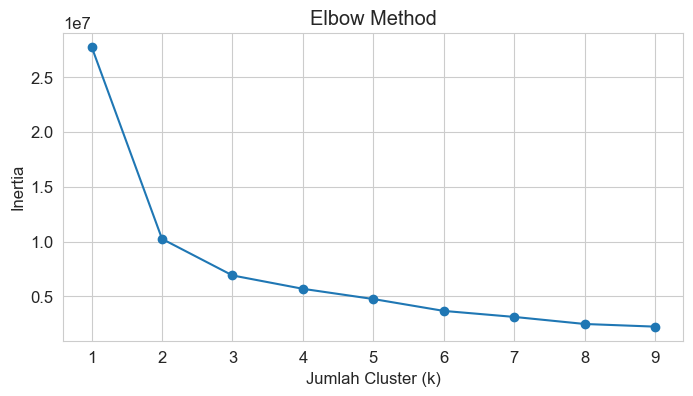

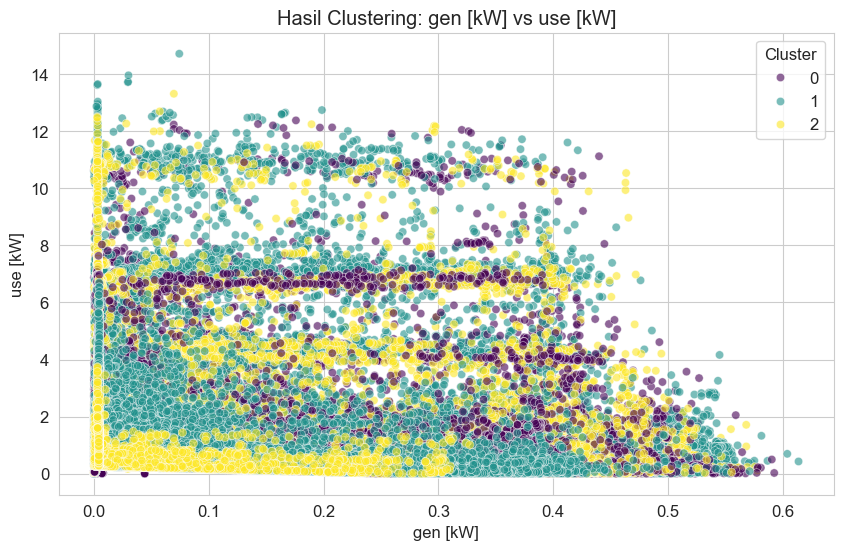

In [74]:
# Gunakan dataset yang sudah dinormalisasi u/ clustering
X_cluster = df_scaled[relevant_features + [target_col]].copy()

# Penentuan K Optimal (Elbow Method)
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Kita pilih k=3
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

# Visualisasi Cluster
feat_x = relevant_features[0] if len(relevant_features) > 0 else 'hour'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=feat_x, y=target_col, hue='Cluster', palette='viridis', alpha=0.6)
plt.title(f'Hasil Clustering: {feat_x} vs {target_col}')
plt.show()



## 7. Predictive Modeling (Regression)
Tahap ini bertujuan untuk membangun model regresi guna memprediksi nilai konsumsi energi berdasarkan fitur-fitur yang telah dipilih.



In [75]:
# Split Data
X = df[relevant_features]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)
print("Pembangunan model selesai.")



Pembangunan model selesai.


## 8. Evaluasi Model
Tahap ini bertujuan untuk mengukur performa model yang telah dibangun menggunakan metrik evaluasi statistik (MAE, RMSE, R2 Score) dan metrik clustering (Silhouette Score).



Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
R2 Score: 1.0000
Silhouette Score (Clustering): 0.3918


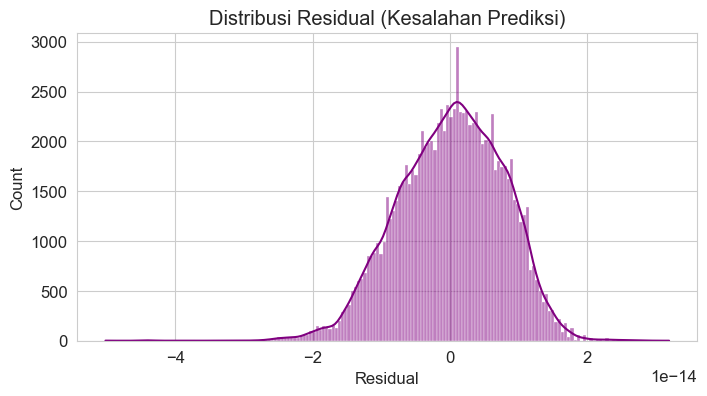

In [76]:
# Evaluasi Regresi
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# Evaluasi Clustering (Silhouette Score)
if len(X_cluster) > 10000:
    X_sample = X_cluster.sample(10000, random_state=42)
    cluster_labels = df.loc[X_sample.index, 'Cluster']
    sil_score = silhouette_score(X_sample, cluster_labels)
else:
    sil_score = silhouette_score(X_cluster, df['Cluster'])

print(f"Silhouette Score (Clustering): {sil_score:.4f}")

# Plot Residuals
plt.figure(figsize=(8, 4))
sns.histplot(y_test - y_pred, kde=True, color='purple')
plt.title('Distribusi Residual (Kesalahan Prediksi)')
plt.xlabel('Residual')
plt.show()

